<a href="https://colab.research.google.com/github/tommasomncttn/NAS4CNN/blob/main/Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing single CNN

### Importing 

In [21]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import random

### Dataset 

In [4]:
class TensorizedDigits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode = "train", transforms = None, tensorized = True):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

        if tensorized:
          self.transforms = TensorizedDigits.tensorization_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        
        if True:
          sample_x, sample_y = self.transforms(sample_x, sample_y)
        

        return (sample_x, sample_y)

    @staticmethod
    def tensorization_transform(x, y):
        
        # reshape to get a valid input for a CNN
        sample_x = x.reshape(1, 8, 8)
        sample_y = y

        # transform it to torch tensor to move them to cuda
        if torch.cuda.is_available():

          sample_x = torch.from_numpy(sample_x).to("cuda")
          sample_y = np.array(y)
          sample_y = torch.from_numpy(sample_y).to("cuda")


        return sample_x, sample_y
    
    def visualize_datapoint(self, idx):

      x,y = self.__getitem__( idx)
      plt.imshow(x[0].cpu(), cmap="gray")
      plt.axis("off")
      plt.show()


### Module

In [5]:
class SingleConfigCNN(nn.Module):
    '''Conv2d → f(.) → Pooling → Flatten → Linear 1 → f(.) → Linear 2 → Softmax
    '''
    def __init__(self, cnn_i_N = 1, cnn_o_N = 8, cnn_k_size = 3, stride = 1, padding = 1, pool_k_size = 2, fnn_o_N = 10):
        super(SingleConfigCNN, self).__init__()

        self.cnn_i_N = cnn_i_N
        self.cnn_o_N = cnn_o_N
        self.cnn_k_size = cnn_k_size
        self.stride = stride
        self.padding = padding
        self.pool_k_size = pool_k_size
        self.fnn_o_N = fnn_o_N
        
        self.cnn =  nn.Conv2d(in_channels = cnn_i_N, out_channels = cnn_o_N, kernel_size = cnn_k_size, stride = stride, padding = padding)
        self.activation1 = nn.ReLU() # or sigmoid, tanh, softplus, elu
        self.pool = nn.MaxPool2d(kernel_size = pool_k_size) # or avg pool
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(in_features = self.compute_input_2_linear(), out_features = fnn_o_N)
        self.activation2 = nn.ReLU() # or sigmoid, tanh, softplus, elu
        self.linear2 = nn.Linear(in_features = fnn_o_N, out_features = 10)
        self.softmax = nn.LogSoftmax(dim=1)

        self.nll = nn.NLLLoss(reduction="none") 
    
    def compute_input_2_linear(self):

        # computing after convolution => [(W-K+2P)/S]+1
        after_cnn_channels = self.cnn_o_N
        after_cnn_height = after_cnn_width = ((8 - self.cnn_k_size + 2 * self.padding) / self.stride) + 1

        # computing after pooling => fixed values stride=kernel_dimension, padding=0, dilation=1 => formula at end of https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
        after_pool_height = after_pool_width = ((after_cnn_height - self.pool_k_size) / self.pool_k_size ) + 1

        # computing after flattening 

        return int(after_pool_height * after_pool_width * after_cnn_channels)

    def classify(self, log_prob):
        
        y_pred = torch.argmax(log_prob, dim = 1).long()        
        return y_pred

    def forward(self, x):
        
        x = self.cnn(x)
        x = self.activation1(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation2(x)
        x = self.linear2(x)
        log_prob = self.softmax(x)

        return log_prob


    def compute_loss(self, log_prob, y, reduction="avg"):

        loss = self.nll(log_prob, y)

        if reduction == "sum":
            return loss.sum()

        else:
            return loss.mean()

    def count_misclassified(self, predictions, targets):

        e = 1.0 * (predictions == targets)
        misclassified = (1.0 - e).sum().item()

        return misclassified

### Training and Validation Loop

In [6]:
def configure_optimizer(model, lr = 1e-3, wd = 1e-5):
  return torch.optim.Adamax(model.parameters(), lr=lr, weight_decay=wd)

In [7]:
def train_one_epoch(dataloader, model, optimizer, epoch_n = None):

    model.train()

    size = len(dataloader.dataset)
    total_loss = 0
    total_miss = 0
    train_step = 0

    for (X, y) in dataloader:

        train_step += 1

        # logits
        log_prob = model(X)

        # classification
        predictions = model.classify(log_prob)

        # misclassified 
        missclassified = model.count_misclassified(predictions, y)
        total_miss += missclassified

        # loss
        loss = model.compute_loss(log_prob, y, reduction = "sum")
        total_loss += loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    
    # compute epoch statistics
    avg_loss = total_loss / size
    avg_ce = total_miss / size
    
    
    print("")
    print(f" TRAINING => Results of epoch number {epoch_n}:")
    print('')
    print('    Average training loss: {0:.5f}'.format(avg_loss))
    print('    Average training classification error: {0:.5f}'.format(avg_ce))

    return avg_loss.item(), avg_ce


In [8]:
def evaluation_one_epoch(dataloader, model, optimizer, mode = "validation", epoch_n = None):

    model.eval()

    size = len(dataloader.dataset)
    total_loss = 0
    total_miss = 0
    val_step = 0


    with torch.no_grad():

      for (X, y) in dataloader:

          val_step += 1

          # logits
          log_prob = model(X)

          # classification
          predictions = model.classify(log_prob)

          # misclassified 
          missclassified = model.count_misclassified(predictions, y)
          total_miss += missclassified

          # loss
          loss = model.compute_loss(log_prob, y, reduction = "sum")
          total_loss += loss



    # compute epoch statistics
    avg_loss = total_loss / size
    avg_ce = total_miss / size
    
    if mode == "validation":

      
      print('')
      print('    Average validation loss: {:.5f}'.format(avg_loss))
      print('    Average validation classification error: {:.5f}'.format(avg_ce))


    else:

  
      print("")
      print(f"TESTING => Results of over test set")
      print('')
      print('    Average test loss: {:.5f}'.format(avg_loss))
      print('    Average test classification error: {0:.5f}'.format(avg_ce))


    return avg_loss.item(), avg_ce


In [9]:
def fit_epochs(training_loader, val_loader, test_loader, model, optimizer, n_epochs, test_model = True):

  train_loss_list = []
  train_ce_list = []
  val_loss_list = []
  val_ce_list = []
  test_loss_result = []
  test_ce_result = []

  for i in range(0,n_epochs):

    train_loss, train_ce =  train_one_epoch(dataloader = training_loader, model = model, optimizer = optimizer, epoch_n = i)
    train_loss_list.append(train_loss)
    train_ce_list.append(train_ce)

    val_loss, val_ce = evaluation_one_epoch(dataloader = val_loader, model = model, optimizer = optimizer, epoch_n = i)
    val_loss_list.append(val_loss)
    val_ce_list.append(val_ce)

  if test_model:
    test_loss, test_ce = evaluation_one_epoch(dataloader = test_loader, model = model, optimizer = optimizer, mode = "test", epoch_n = i)
    test_loss_result.append(test_loss)
    test_ce_result.append(test_ce)


    result_dic = {"train_loss_list": train_loss_list, "train_ce_list": train_ce_list,"val_loss_list":val_loss_list, "val_ce_list":val_ce_list, "test_loss_result":test_loss_result, "test_ce_result":test_ce_result, "number_of_epochs" : n_epochs}
  else: 
    result_dic = {"train_loss_list": train_loss_list, "train_ce_list": train_ce_list,"val_loss_list":val_loss_list, "val_ce_list":val_ce_list, "number_of_epochs" : n_epochs}
  return result_dic


In [10]:
def plot_results(results):
    # Extracting the data from the dictionary
    train_loss_list = results["train_loss_list"]
    train_ce_list = results["train_ce_list"]
    val_loss_list = results["val_loss_list"]
    val_ce_list = results["val_ce_list"]
    test_loss_result = results["test_loss_result"]
    test_ce_result = results["test_ce_result"]
    n_epochs = results["number_of_epochs"]

    # Plotting losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs + 1), train_loss_list, label="Train Loss")
    plt.plot(range(1, n_epochs + 1), val_loss_list, label="Validation Loss")
    plt.plot(range(1, n_epochs + 1), [test_loss_result] * n_epochs, label="Test Loss", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Losses")
    plt.legend()

    # Plotting classification errors
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_epochs + 1), train_ce_list, label="Train Classification Error")
    plt.plot(range(1, n_epochs + 1), val_ce_list, label="Validation Classification Error")
    plt.plot(range(1, n_epochs + 1), [test_ce_result] * n_epochs, label="Test Classification Error", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Classification Error")
    plt.title("Training and Evaluation Classification Errors")
    plt.legend()

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


### Inference 

In [11]:
# Initialize training, validation and test sets.
train_data = TensorizedDigits(mode="train")
val_data = TensorizedDigits(mode="val")
test_data = TensorizedDigits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [12]:
cnn = SingleConfigCNN() #.to("cuda")

In [13]:
opt = configure_optimizer(cnn)
results = fit_epochs(training_loader, val_loader, test_loader, model = cnn, optimizer = opt, n_epochs = 20)


 TRAINING => Results of epoch number 0:

    Average training loss: 2.26684
    Average training classification error: 0.85400

    Average validation loss: 2.13455
    Average validation classification error: 0.82857

 TRAINING => Results of epoch number 1:

    Average training loss: 2.14341
    Average training classification error: 0.83400

    Average validation loss: 2.05628
    Average validation classification error: 0.78571

 TRAINING => Results of epoch number 2:

    Average training loss: 2.06836
    Average training classification error: 0.80000

    Average validation loss: 1.98926
    Average validation classification error: 0.76286

 TRAINING => Results of epoch number 3:

    Average training loss: 2.00418
    Average training classification error: 0.74000

    Average validation loss: 1.93292
    Average validation classification error: 0.73714

 TRAINING => Results of epoch number 4:

    Average training loss: 1.94817
    Average training classification error: 0.69

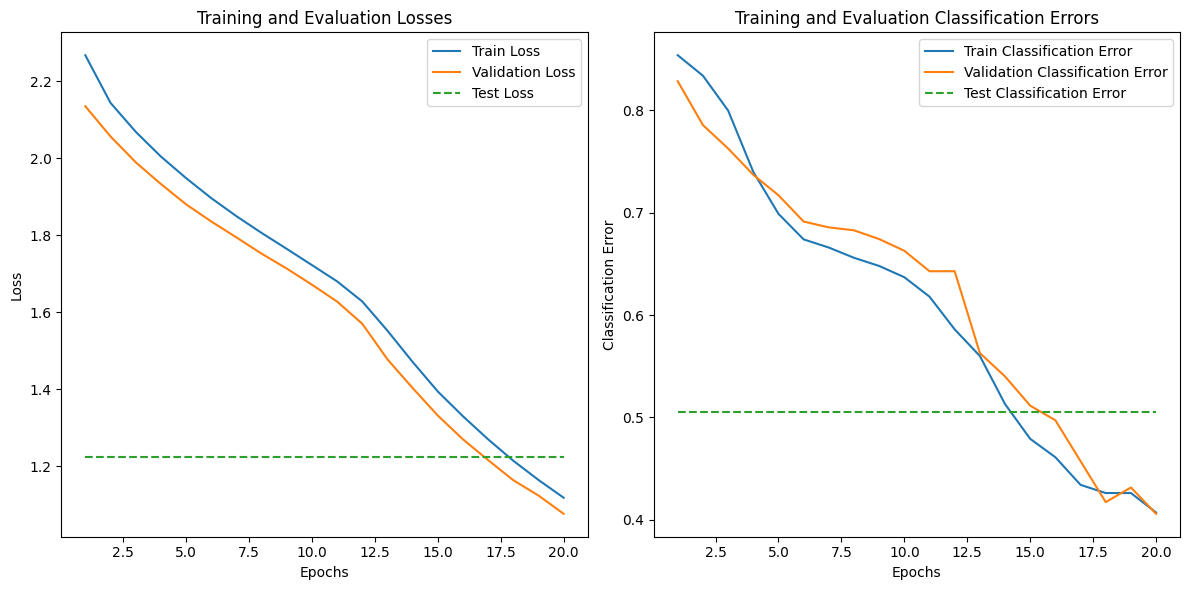

In [14]:
plot_results(results)

# Implementing Multiple CNN

### Multi Module

In [15]:
class MultiConfigCNN(nn.Module):
    '''Conv2d → f(.) → Pooling → Flatten → Linear 1 → f(.) → Linear 2 → Softmax
    '''
    def __init__(self, config, cnn_i_N = 1, pool_k_size = 2, fnn_o_N = 10):
        super(MultiConfigCNN, self).__init__()

        self.config = config 

        self.cnn_i_N = cnn_i_N
        self.cnn_o_N = self.config["conv_filters"]
        self.cnn_k_size = self.config["cnn_architectures"]["kernel_size"]
        self.stride = self.config["cnn_architectures"]["stride"]
        self.padding = self.config["cnn_architectures"]["padding"]
        self.pool_k_size = pool_k_size
        self.fnn_o_N = self.config["linear_1_neurons"]
        self.pooling_type = self.config["pooling"]["pooling_type"]
        
        self.cnn =  nn.Conv2d(in_channels = cnn_i_N, out_channels = self.cnn_o_N, kernel_size = self.cnn_k_size, stride = self.stride, padding = self.padding)
        self.activation1 = self.config["activation"] 
        if self.pooling_type != "Average":
          self.pool = nn.MaxPool2d(kernel_size = pool_k_size) 
        else:
          self.pool = nn.AvgPool2d(kernel_size = pool_k_size) 
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(in_features = self.compute_input_2_linear(), out_features = fnn_o_N)
        self.activation2 = self.config["activation"] 
        self.linear2 = nn.Linear(in_features = fnn_o_N, out_features = 10)
        self.softmax = nn.LogSoftmax(dim=1)

        self.nll = nn.NLLLoss(reduction="none") 
    
    def compute_input_2_linear(self):

        # computing after convolution => [(W-K+2P)/S]+1
        after_cnn_channels = self.cnn_o_N
        after_cnn_height = after_cnn_width = ((8 - self.cnn_k_size + 2 * self.padding) / self.stride) + 1
        
        # computing after pooling => fixed values stride=kernel_dimension, padding=0, dilation=1 => formula at end of https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
        after_pool_height = after_pool_width = ((after_cnn_height - self.pool_k_size) / self.pool_k_size ) + 1

        # computing after flattening 

        return int(after_pool_height * after_pool_width * after_cnn_channels)

    def classify(self, log_prob):
        
        y_pred = torch.argmax(log_prob, dim = 1).long()        
        return y_pred

    def forward(self, x):
        
        x = self.cnn(x)
        x = self.activation1(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation2(x)
        x = self.linear2(x)
        log_prob = self.softmax(x)

        return log_prob


    def compute_loss(self, log_prob, y, reduction="avg"):

        loss = self.nll(log_prob, y)

        if reduction == "sum":
            return loss.sum()

        else:
            return loss.mean()

    def count_misclassified(self, predictions, targets):

        e = 1.0 * (predictions == targets)
        misclassified = (1.0 - e).sum().item()
        
        return misclassified

    @staticmethod
    def possible_config():
      possible_config = {
    "conv_filters": [8, 16, 32],
    "cnn_architectures": [
        {"kernel_size": 3, "stride" : 1, "padding" : 1},
     {"kernel_size": 5, "stride" : 1, "padding" : 2}
     ],
    "activation": [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softplus(), nn.ELU],
    "pooling": [
        {"kernel_size": 2, "pooling_type": "Average"},
        {"kernel_size": 2, "pooling_type": "Maximum"},
        {"kernel_size": "Identity", "pooling_type": "Average"},
        {"kernel_size": "Identity", "pooling_type": "Maximum"}
    ],
    "linear_1_neurons": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
      return possible_config


### Inference

In [16]:
picked_config = {
    "conv_filters": 32,
    "cnn_architectures": {"kernel_size": 5, "stride" : 1, "padding" : 2},
    "activation": nn.ReLU(),
    "pooling": {"kernel_size": 2, "pooling_type": "Average"},
    "linear_1_neurons": 100
}

In [17]:
# Initialize training, validation and test sets.
train_data = TensorizedDigits(mode="train")
val_data = TensorizedDigits(mode="val")
test_data = TensorizedDigits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [19]:
multicnn = MultiConfigCNN(picked_config)

In [20]:
opt = configure_optimizer(multicnn)
results = fit_epochs(training_loader, val_loader, test_loader, model = multicnn, optimizer = opt, n_epochs = 20)


 TRAINING => Results of epoch number 0:

    Average training loss: 2.22250
    Average training classification error: 0.83100

    Average validation loss: 2.07404
    Average validation classification error: 0.77429

 TRAINING => Results of epoch number 1:

    Average training loss: 1.92929
    Average training classification error: 0.64600

    Average validation loss: 1.86374
    Average validation classification error: 0.58857

 TRAINING => Results of epoch number 2:

    Average training loss: 1.67637
    Average training classification error: 0.47800

    Average validation loss: 1.62673
    Average validation classification error: 0.45714

 TRAINING => Results of epoch number 3:

    Average training loss: 1.44524
    Average training classification error: 0.42300

    Average validation loss: 1.42736
    Average validation classification error: 0.37714

 TRAINING => Results of epoch number 4:

    Average training loss: 1.25749
    Average training classification error: 0.35

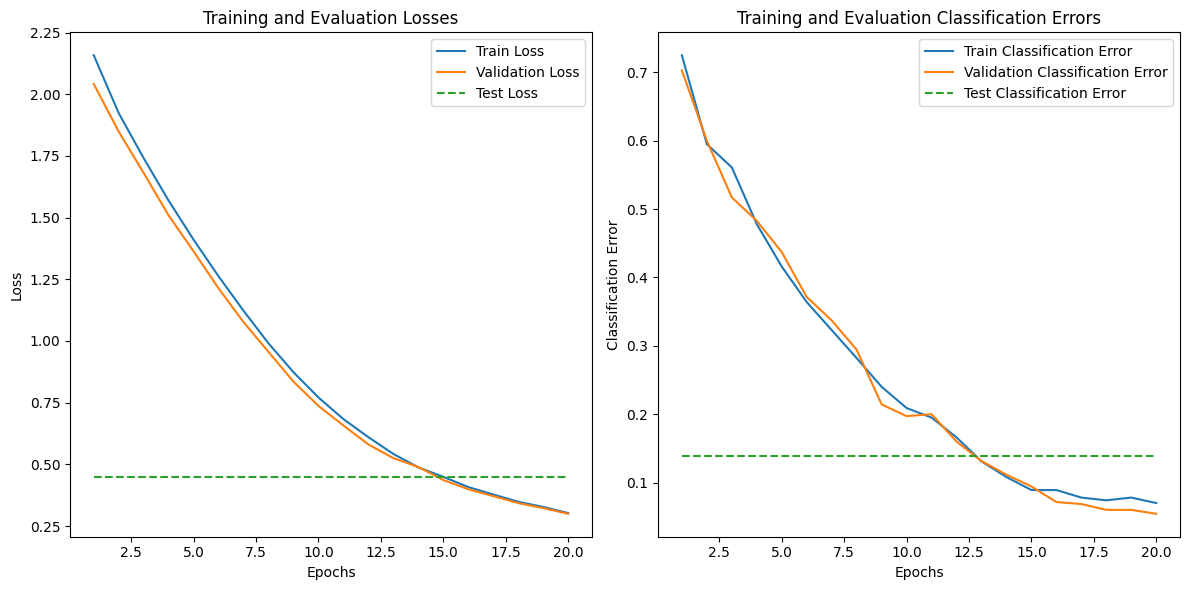

In [ ]:
plot_results(results)

# Evolutionary Algorithm 

In [31]:
class Utils4EA():

  def __init__(self):
    pass

  @staticmethod
  def check_validity_genotype(input_list):
    list_lengths = [3, 2, 5, 4, 10]

    if len(input_list) != sum(list_lengths):
        return False

    index = 0
    for length in list_lengths:
        sublist = input_list[index:index+length]
        sampled_values = list(range(length))

        if not all(value in sampled_values for value in sublist):
            return False

        index += length

    return True
    
  @staticmethod
  def generate_random_genotype():
    list_lengths = [3, 2, 5, 4, 10]  # Number of elements in each sublist
    random_list = []

    for length in list_lengths:
        sublist = random.sample(range(length), 1)  # Randomly select an element from the sublist
        random_list.extend(sublist)

    return random_list


  @staticmethod
  def generate_random_phenotype():
    genotype = {
        "conv_filters": random.choice([8, 16, 32]),
        "cnn_architecture": random.choice([
            {"kernel_size": 3, "stride": 1, "padding": 1},
            {"kernel_size": 5, "stride": 1, "padding": 2}
        ]),
        "activation": random.choice([nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softplus(), nn.ELU()]),
        "pooling": random.choice([
            {"kernel_size": 2, "pooling_type": "Average"},
            {"kernel_size": 2, "pooling_type": "Maximum"},
            {"kernel_size": "Identity", "pooling_type": "Average"},
            {"kernel_size": "Identity", "pooling_type": "Maximum"}
        ]),
        "linear_1_neurons": random.choice([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    }
    return genotype


  @staticmethod
  def genotype_space():
    genotype_space = {}
    for key, value in Utils4EA().phenotype_space().items():
      value_length = len(value)  # Length of the item
      dimension_space = range(0,value_length)
      genotype_space[key] = dimension_space

    return genotype_space


  @staticmethod
  def phenotype_space():

    possible_config = {
  "conv_filters": [8, 16, 32],
  "cnn_architectures": [
      {"kernel_size": 3, "stride" : 1, "padding" : 1},
    {"kernel_size": 5, "stride" : 1, "padding" : 2}
    ],
  "activation": [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softplus(), nn.ELU],
  "pooling": [
      {"kernel_size": 2, "pooling_type": "Average"},
      {"kernel_size": 2, "pooling_type": "Maximum"},
      {"kernel_size": "Identity", "pooling_type": "Average"},
      {"kernel_size": "Identity", "pooling_type": "Maximum"}
  ],
  "linear_1_neurons": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
    return possible_config

In [ ]:
class EA(object):

    def __init__(self, pop_size = 20, lAmbda =0.01 bounds_min=None, bounds_max=None):

        # load the constructor parameters as attributes
        self.pop_size = pop_size
        self.lAmbda = lAmbda
        self.max_num_param = 7362

        # define the genotypespace TODO
        self.bounds_min = bounds_min
        self.bounds_max = bounds_max

        # dataset and dataloader
        self.train_data = TensorizedDigits(mode="train")
        self.val_data = TensorizedDigits(mode="val")
        self.test_data = TensorizedDigits(mode="test")
        self.training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
        self.val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
        self.test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

    # -------
        # FOR NN
    # -------

    def evaluate(self, x): # x must be a list of models
        fitness_list = []
        for model in x:

          opt = configure_optimizer(model)
          results = fit_epochs(self.training_loader, self.val_loader, self.test_loader, model = model, optimizer = opt, n_epochs = 10, test_model = False)
          
          num_params = sum(p.numel() for p in model.parameters())
          if num_params > self.max_num_param:
            raise ValueError("Compute again, unbeliavable shame")
          fitness = results["val_ce_list"] + self.lambdap*(num_params/self.max_num_param)
          fitness_list.append(fitness)
        
        return fitness_list


    def config_from_single_genotype(self, genotype):

      # checking genotype validity
      is_valid = Utils4EA.check_validity_genotype(genotype)
      if not(is_valid):
        raise ValueError("Invalid Genotype")
      
      # importing phenotype space
      phenotypespace = Utils4EA.phenotype_space()

      # get the phenotype
      phenotype_config = {
            "conv_filters": phenotypespace["conv_filters"][genotype[0]],
            "cnn_architectures": phenotypespace["cnn_architectures"][genotype[1]],
            "activation": phenotypespace["activation"][genotype[2]],
            "pooling": phenotypespace["pooling"][genotype[3]],
            "linear_1_neurons": phenotypespace["linear_1_neurons"][genotype[4]]
                  }
      return phenotype_config


    def encoding_population(self, genotypes):
      phenotypes = []
      for genotype in genotypes:
        phenotype_config = self.encoding_single_genotype(self, genotype)
        phenotype = MultiConfigCNN(phenotype_config)
        phenotypes.append(phenotype)
      return phenotypes
        
        
      
    
    # -------
        # FOR EVOLUTIONARY ALGORITHM
    # -------

    def recombination(self, x_parents, f_parents):
        
        pass # return x_children

    def mutation(self, x_children):

      pass # return x_children
      

    def survivor_selection(self, x_parents_geno, x_children_geno, f_parents, f_children):
      '''we pass from a set of FINAL candidate solution, to the new population
      by selecting the best individuals
      '''

      # concatenate miu and lambda, old population and candidate solution
      x = np.concatenate([x_parents_geno, x_children_geno])

      # concate their fitness
      f = np.concatenate([f_parents, f_children])

      # sort them, the lefter the better
      index = np.argsort(f)
      x = x[index]
      f = f[index]

      # return only the best pop size (miu)
      return x[:self.pop_size], f[:self.pop_size]

    # -------
        # STEP
    # -------

    def step(self, x_parents_geno, f_parents):

        # recombination step 
        x_children = self.recombination(x_parents_geno, f_parents)
        
        # mutation step
        x_children_geno = self.mutation(x_children_geno)

        # encoding step 
        x_children_pheno = self.encoding(x_children_geno)

        # evaluation step 
        f_children = self.evaluate(x_children_pheno)

        x, f = self.survivor_selection(x_parents_geno, x_children_geno, f_parents, f_children)

        return x, f